In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)

speculator.params_name += ['logm', 'redshift']
speculator._build_params_prior()
speculator.bounds = np.array([speculator.prior[key] for key in speculator.params_name])
# speculator.network.eval();

noise = None # 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [4]:
def gen_truth(sfh_kwargs, logz_logm_kwargs, 
              dust2_kwargs, redshift_kwargs, 
              nsamples=5000, random_state=None):
    from torch.distributions import MultivariateNormal
    if random_state is not None:
        torch.manual_seed(random_state)
    y_sfh = MultivariateNormal(torch.Tensor(sfh_kwargs['loc']), 
                               covariance_matrix=torch.Tensor(sfh_kwargs['cov'])
                              ).sample(sample_shape=(nsamples,))
    
    y_logz_logm = MultivariateNormal(torch.Tensor(logz_logm_kwargs['loc']), 
                                     torch.Tensor(logz_logm_kwargs['cov'])
                                    ).sample(sample_shape=(nsamples // 2,))
    y_logz_logm = torch.vstack([y_logz_logm, MultivariateNormal(torch.Tensor([-0.5, 8.5]), 
                             torch.Tensor(logz_logm_kwargs['cov']) * 0.5,
                            ).sample(sample_shape=(nsamples // 2,))])

    y_dust2 = torch.normal(mean=dust2_kwargs['mean'], std=dust2_kwargs['std'], size=(nsamples, 1))
    y_redshift = torch.normal(mean=redshift_kwargs['mean'], std=redshift_kwargs['std'], size=(nsamples, 1))
    
    Y_truth = torch.hstack([y_sfh, y_logz_logm[:, 0:1], y_dust2, y_logz_logm[:, 1:], y_redshift]).to('cuda')
    return Y_truth

In [5]:
sfh_kwargs = {'loc': [6, 0], 'cov': [[1, 0], [0, 0.3]]}
logz_logm_kwargs = {'loc': [-0.5, 10.5], 
                    'cov': [[0.3, 0.2], 
                            [0.4, 0.6]]}
dust2_kwargs = {'mean': 1, 'std': 0.5}
redshift_kwargs = {'mean': 0.15, 'std': 0.03}

In [6]:
Y_truth = gen_truth(sfh_kwargs, logz_logm_kwargs, 
                    dust2_kwargs, redshift_kwargs,
                    nsamples=5000, random_state=None)

In [7]:
# filters = ['galex_NUV'] + ['sdss_{0}0'.format(b) for b in 'ugriz'] + ['hsc_{0}'.format(b) for b in 'grizy']
filters = ['galex_NUV'] + ['hsc_{0}'.format(b) for b in 'grizy'] + ['jwst_f090w', 'jwst_f115w', 'jwst_f140m']

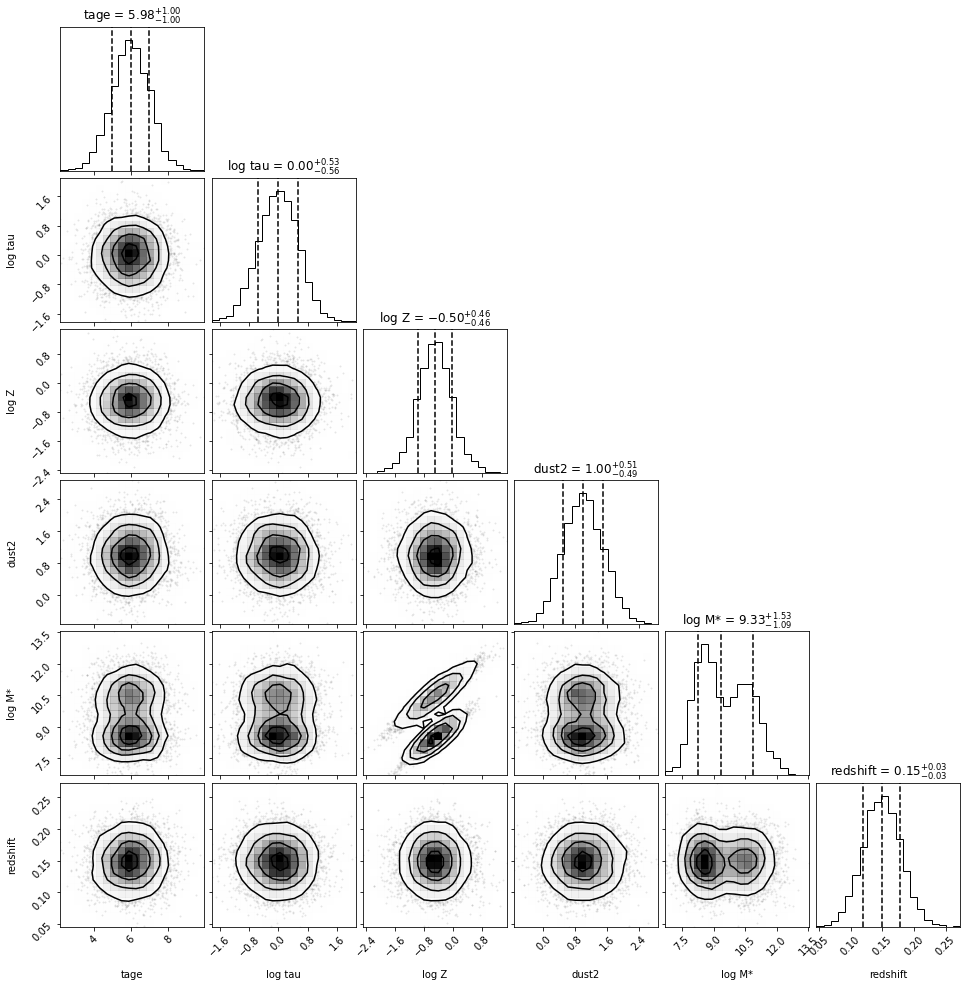

In [8]:
X_data = speculator._predict_mag_with_mass_redshift(
    Y_truth,
    filterset=filters,
    noise=noise, 
    noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

figure = corner.corner(Y_truth.cpu().detach().numpy(),
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [9]:
filelist = os.listdir('./nde_theta_TZD_multiband/')#[:6]
filelist

['nde_theta_best_loss_nsf_449.pkl',
 'nde_theta_best_loss_nsf_734.pkl',
 'nde_theta_best_loss_nsf_996.pkl',
 'nde_theta_best_loss_nsf_589.pkl',
 'nde_theta_best_loss_nsf_247.pkl',
 'nde_theta_best_loss_nsf_377.pkl',
 'nde_theta_best_loss_nsf_148.pkl']

In [10]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE_list.append(pickle.load(open('./nde_theta_TZD_multiband/' + file, 'rb')))
    except Exception as e:
        print(file, e)
        continue

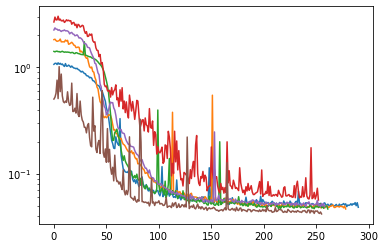

In [11]:
[plt.plot(NDE.train_loss_history) for NDE in NDE_list[:5] + NDE_list[-1:]]
plt.yscale('log')

In [12]:
samples = torch.dstack([NDE.sample(2000) for NDE in NDE_list[:5] + NDE_list[-1:]])

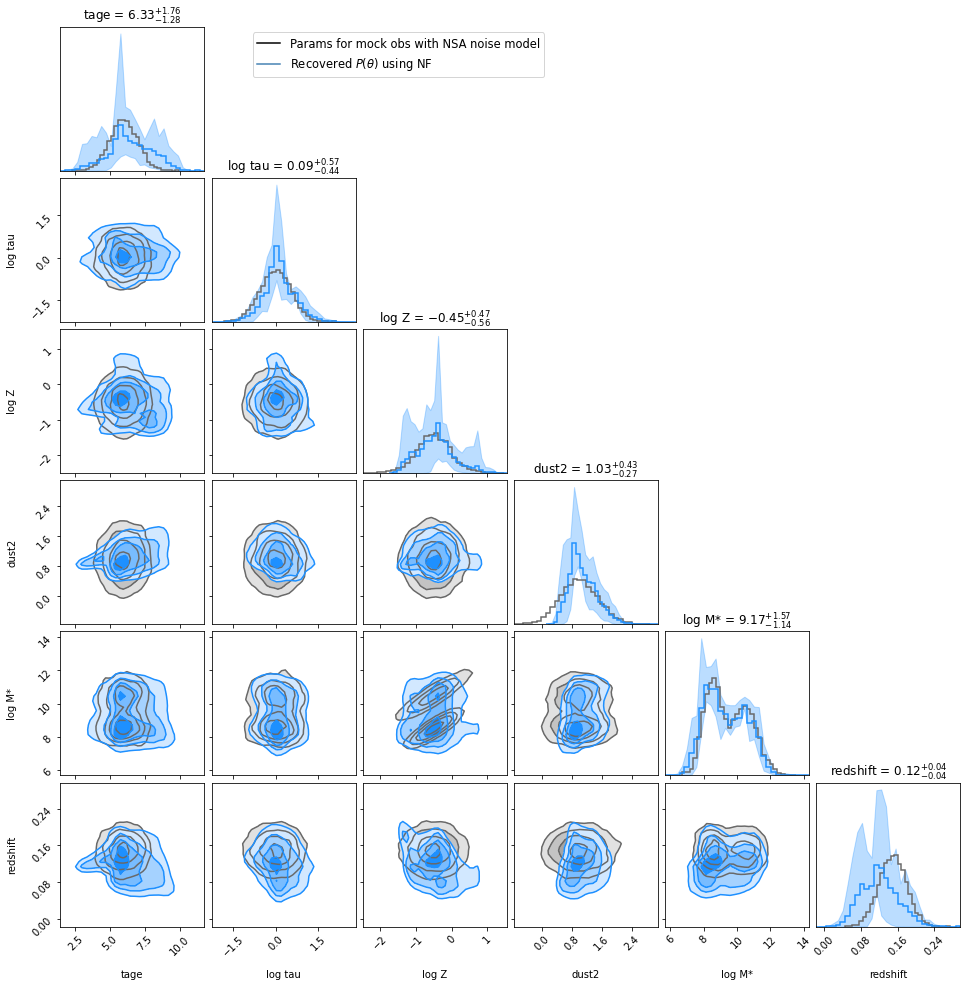

In [13]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs with NSA noise model')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=30,
                       smooth=0.8, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True, 'lw': 1.5}, 
                       plot_datapoints=False)

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                        fig=figure, labels=labels, bins=30,
                        color='dodgerblue',
                        smooth=0.8, fill_contours=True,
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True, 'lw': 1.5}, 
                        plot_datapoints=False)
ax = nf_plot.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [37]:
np.log10(L(X_data, torch.Tensor(mags).to('cuda')).item()) # The distance in theta space

-0.9776024742334073

In [45]:
NDE_theta = NDE_list[0]

In [37]:
samples.swapaxes(0, 1).reshape(6, -1).T.shape

torch.Size([14000, 6])

0 12000


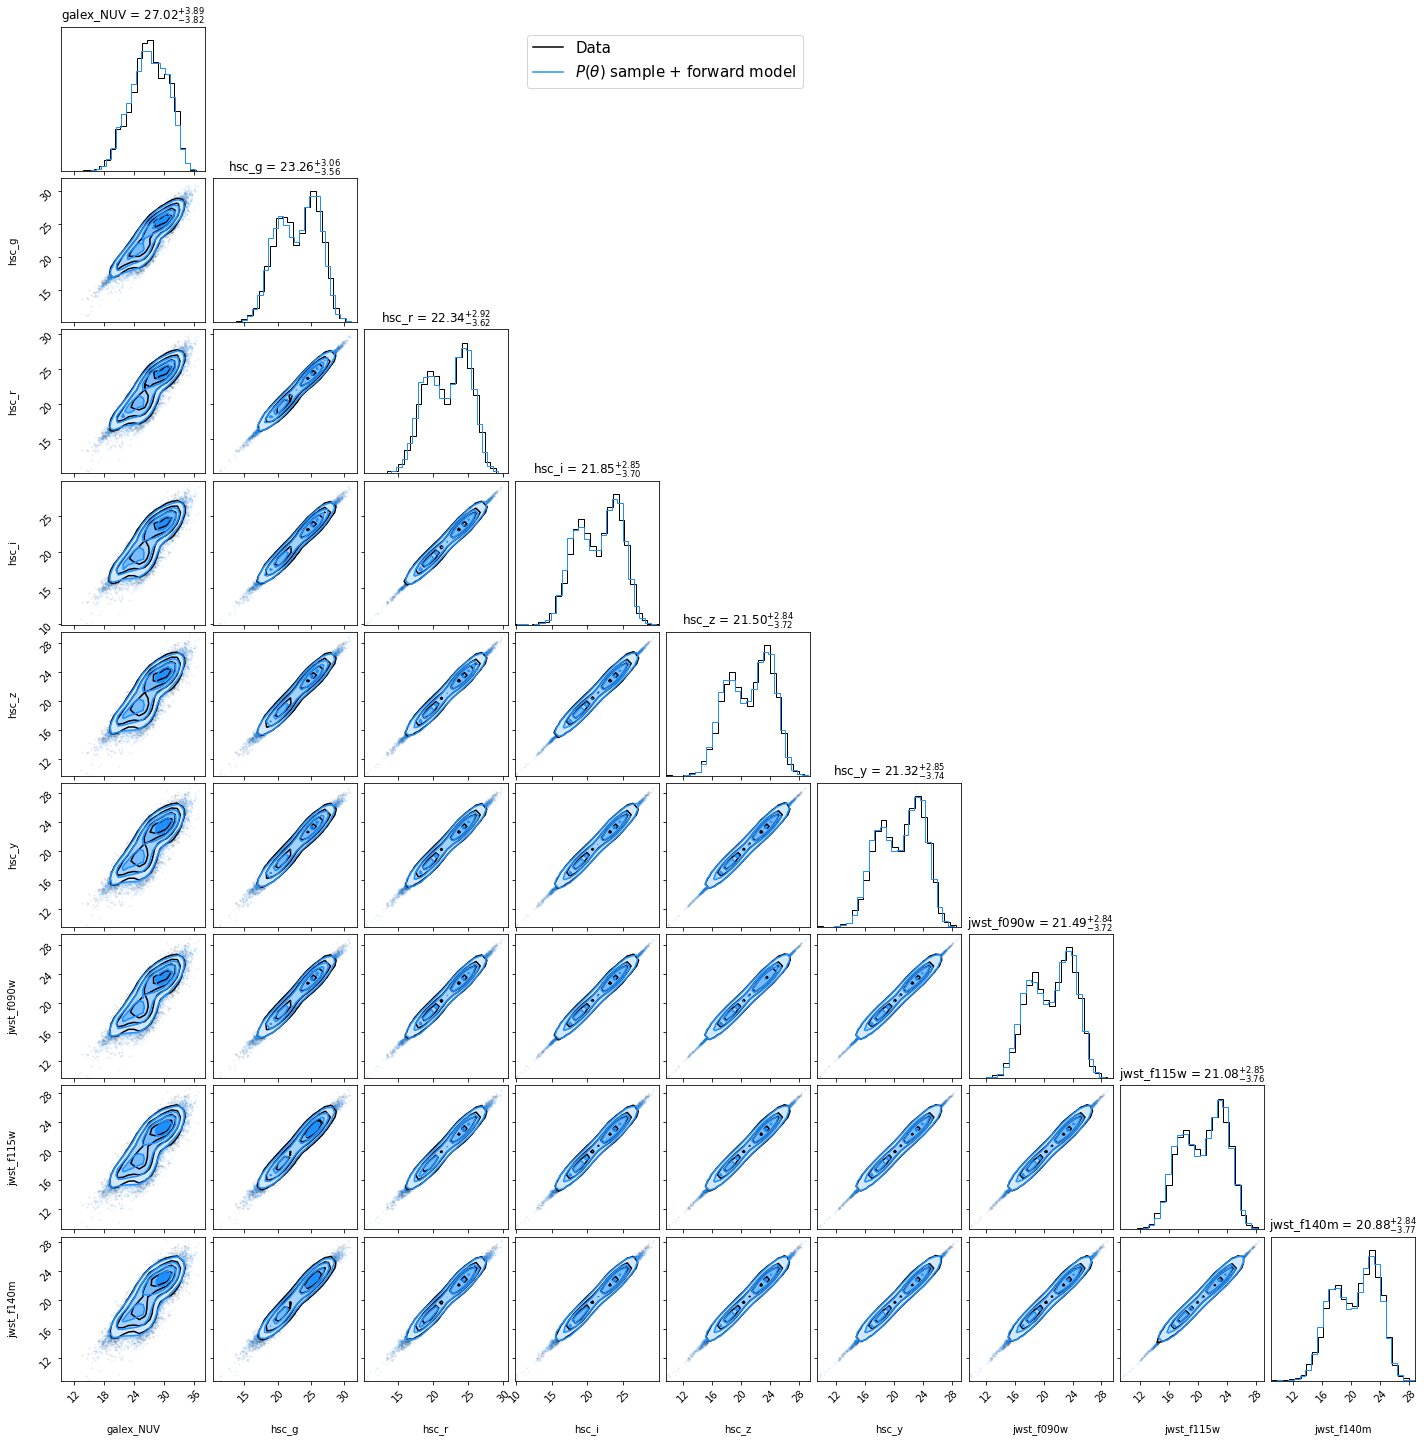

In [14]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       hist_kwargs={'density': True, 'lw': 1.}, 
                       title_kwargs={"fontsize": 12},
                       plot_datapoints=True)

mags = speculator._predict_mag_with_mass_redshift(samples.swapaxes(0, 1).reshape(6, -1).T,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]

nf_plot = corner.corner(mags,
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12},
                        hist_kwargs={'density': True, 'lw': 1.}, 
                        plot_datapoints=True)

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))